This data is take from [kaggle](https://www.kaggle.com/datasets/hojjatk/mnist-dataset).  This notebook will go through multi-class classification methods for classifiying the images showing digits 3, 5, and 8.

In [1]:
# Import Required Libraries for Notebook
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

In [2]:
mnist = fetch_openml("mnist_784")

In [3]:
keys = list(mnist.keys())
print(keys)

['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url']


# Data Preparation

In [4]:
df = pd.concat([mnist[keys[0]],mnist[keys[1]]],axis=1)
df

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
69996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
69997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
69998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


Let us visualize one observation (row) of the data set.  There are 784 features corresponding to pixel1,...,pixel784.

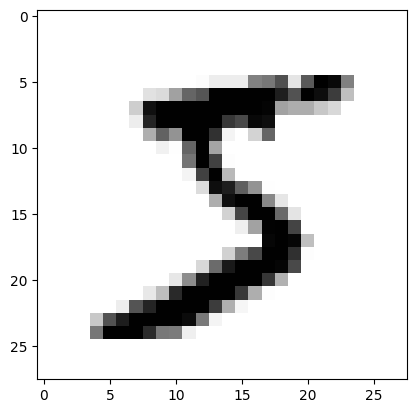


*** Image is classified as a 5 ***


In [5]:
i = 0 #select any row; i = 0 -> row 0
obs = df.iloc[i,:-1].to_numpy()
obs_image = obs.astype(np.uint8).reshape(28, 28)
plt.imshow(obs_image, plt.cm.binary)
plt.show()
print(f'\n*** Image is classified as a {df.loc[i,"class"]} ***')

We are only interested in a 3-digit classification between digits 3, 5, and 8.  Therefore we will perform filtering to extract these relevant datapoints.  Furthermore, as we can see the class (y variable) returns string input.  Let us change this to integers.

In [6]:
df.dtypes.unique()

array([dtype('int64'),
       CategoricalDtype(categories=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], ordered=False, categories_dtype=object)],
      dtype=object)

In [7]:
df['class'] = df['class'].apply(lambda x: int(x))
bool_musk = df['class'].isin([3,5,8])
df = df.loc[bool_musk].reset_index(drop=True)
df

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20274,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
20275,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
20276,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
20277,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


Note, the y values are given by the digit and the x values are given by the array of 0s and 1s.  Now we split the data into training and testing sets; we will use an 80%-20% split between training and testing respectively.

In [8]:
#split data into training and testing
cutoff = int(df.shape[0]*(0.8))
X, y = df.iloc[:,:-1], df['class']
X_train, X_test = X[:cutoff], X[cutoff:]
y_train, y_test = y[:cutoff], y[cutoff:]

#randomize the split
n = X_train.shape[0]
rand = np.random.permutation(n)
X_train = X_train.iloc[list(rand),:].reset_index(drop = True)
y_train = y_train[rand].reset_index(drop = True)

In [9]:
assert X_train.shape[0] + X_test.shape[0] == df.shape[0], 'ERROR'
assert X_train.shape[1] == X_test.shape[1] == df.shape[1] - 1, 'ERROR' #class column == y
assert y_train.shape[0] + y_test.shape[0] == df.shape[0], 'ERROR'

#formats
print(f'X_train: {X_train.shape},\nX_test: {X_test.shape},\ny_train: {y_train.shape},\ny_test: {y_test.shape}')

X_train: (16223, 784),
X_test: (4056, 784),
y_train: (16223,),
y_test: (4056,)


# Classification Methods

First we need to scale the features.

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Store confusion matrix and results in the following dictionary:

In [11]:
results = {'Method':[],'Accuracy':[],'Report':[]}

## Logistic Regression

I will be applying Logistic Regression to classify the data.  Since this is
a multi-class classification problem between digits 3, 5, and 8, I will be using One-vs-Rest.  Therefore I will identify 3 vs (5 and 8), 5 vs (3 and 8), and 8 vs (3 and 5).

In [12]:
# OneVsRestClassifier with LogisticRegressionCV
log_reg_cv = OneVsRestClassifier(
  LogisticRegressionCV(
                      max_iter=1000,      # Maximum iterations
                      cv=5,               # Cross-validation folds
                      n_jobs=-1           # Use all CPU cores for parallel processing
  )
)

log_reg_cv.fit(X_train_scaled, y_train) # Train the model
y_pred1 = log_reg_cv.predict(X_test_scaled) # Predictions
accuracy = accuracy_score(y_test, y_pred1) # Evaluation

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_report(y_test, y_pred1))

Accuracy: 0.9374
Classification Report:
               precision    recall  f1-score   support

           3       0.93      0.95      0.94      1426
           5       0.94      0.92      0.93      1257
           8       0.94      0.95      0.94      1373

    accuracy                           0.94      4056
   macro avg       0.94      0.94      0.94      4056
weighted avg       0.94      0.94      0.94      4056



Clearly, Logistic Regression OVR does very well!  See the confusion matrix below.  We see that there is minimal bias and the images are misclassified evenly with a nice diagonal of correct classification strongly outweighing the misclassifications.

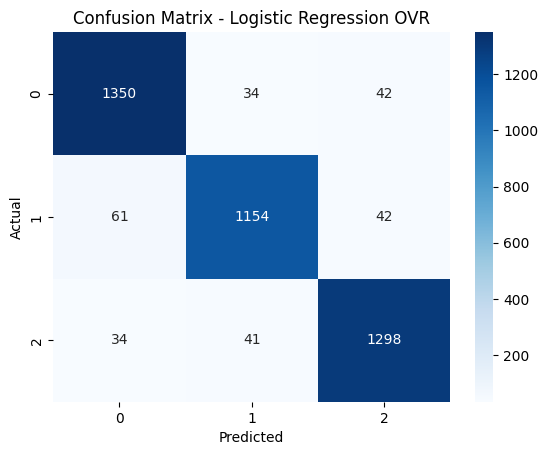

In [13]:
cm = confusion_matrix(y_test, y_pred1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression OVR")
plt.show()

Append data to results dictionary.

In [14]:
results['Method'].append('Logistic Regression OVR')
results['Accuracy'].append(accuracy)
results['Report'].append(classification_report(y_test, y_pred1))

## Multinomial Regression

In [15]:
# Multinomial Logistic Regression with Cross-Validation
log_reg_cv = LogisticRegressionCV(
#   multi_class='multinomial',  # multinomial logistic regression is the default
    max_iter=1000,              # Maximum iterations
    cv=5,                       # Cross-validation folds
    n_jobs=-1                   # Use all CPU cores for parallel processing
)

log_reg_cv.fit(X_train_scaled, y_train) # Train the model
y_pred2 = log_reg_cv.predict(X_test_scaled) # Predictions
accuracy = accuracy_score(y_test, y_pred2) # Evaluation

In [16]:
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_report(y_test, y_pred2))

Accuracy: 0.9384
Classification Report:
               precision    recall  f1-score   support

           3       0.94      0.95      0.94      1426
           5       0.94      0.92      0.93      1257
           8       0.94      0.95      0.94      1373

    accuracy                           0.94      4056
   macro avg       0.94      0.94      0.94      4056
weighted avg       0.94      0.94      0.94      4056



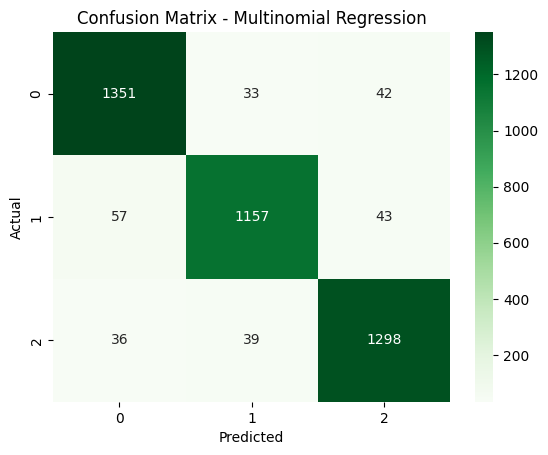

In [17]:
cm = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Multinomial Regression")
plt.show()

Multinomial Regression slightly outperforms Logistic Regression OVR (but I would claim that this outperformance is insignificant).  We can observe that Multinomial Regression yields approximately the same results as Logistic Regression OVR.  

In [18]:
results['Method'].append('Multinomial Regression')
results['Accuracy'].append(accuracy)
results['Report'].append(classification_report(y_test, y_pred2))

## Naive Bayes

For Naive Bayes, there is no hyperparameters to tune; we want to select the best performing model between Gaussian and Bernoulli.

**Gaussian Assumption:**

In [19]:
nb_gaussian = GaussianNB() # Initialize Naive Bayes Classifier (GaussianNB)
nb_gaussian.fit(X_train_scaled, y_train) # Train the model
y_pred3 = nb_gaussian.predict(X_test_scaled) # Predictions

accuracy = accuracy_score(y_test, y_pred3) # Evaluation
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_report(y_test, y_pred3))


Accuracy: 0.4778
Classification Report:
               precision    recall  f1-score   support

           3       0.89      0.34      0.49      1426
           5       0.73      0.10      0.17      1257
           8       0.40      0.97      0.56      1373

    accuracy                           0.48      4056
   macro avg       0.67      0.47      0.41      4056
weighted avg       0.67      0.48      0.42      4056



These results are very poor compared to Logistic Regression OVR and Multinomial Regression.  Let us look at the confusion matrix.

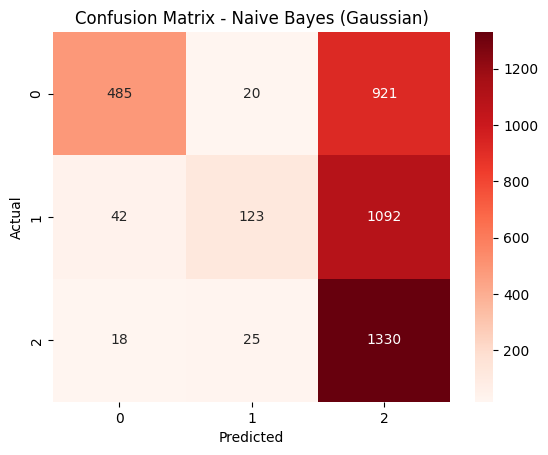

In [20]:
cm = confusion_matrix(y_test, y_pred3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Naive Bayes (Gaussian)")
plt.show()

The digit 8 which corresponds to the hard label 2 was very poorly classified.  The results were horrible.  Let us try and change the assumption away from normal (which clearly is a poor assumption).

In [21]:
results['Method'].append('Naive Bayes (Gaussian)')
results['Accuracy'].append(accuracy)
results['Report'].append(classification_report(y_test, y_pred3))

**Bernoulli Assumption:**

In [22]:
nb_bernoulli = BernoulliNB() # Initialize Bernoulli Naive Bayes Classifier
nb_bernoulli.fit(X_train_scaled, y_train) # Train the model
y_pred4 = nb_bernoulli.predict(X_test_scaled) # Predictions
accuracy = accuracy_score(y_test, y_pred4)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_report(y_test, y_pred4))

Accuracy: 0.8733
Classification Report:
               precision    recall  f1-score   support

           3       0.82      0.90      0.86      1426
           5       0.91      0.82      0.86      1257
           8       0.90      0.89      0.89      1373

    accuracy                           0.87      4056
   macro avg       0.88      0.87      0.87      4056
weighted avg       0.88      0.87      0.87      4056



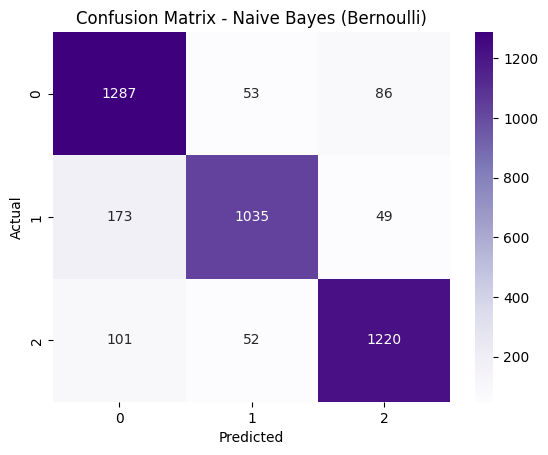

In [23]:
cm = confusion_matrix(y_test, y_pred4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Naive Bayes (Bernoulli)")
plt.show()

The reason we may be seeing a better performance in Naive Bayes with the Bernoulli distribution opposed to Naive Bayes with the Gaussian distribution on the MNIST dataset is related to the nature of the data.

The Bernoulli Naive Bayes model assumes that each feature (pixel in this case) is binary, i.e., it either indicates the presence or absence of a certain feature. This assumption fits well with MNIST data, where each pixel is either "on" or "off" (a value greater than 0) in the context of image processing.

On the other hand, the Gaussian Naive Bayes assumes that the features are continuous and follow a normal distribution. While this might work well for continuous data, MNIST data consists of pixel values that are discrete integers in the range from 0 to 255. As a result, Gaussian Naive Bayes might not capture the distribution of pixel values as effectively as Bernoulli Naive Bayes.

These results are a lot better and rival Logistic Regression OVR and Multinomial Regression.  I would still claim that Logistic Regression OVR and Multinomial Regression outperform Naive Bayes.  However, the computational costs of running Naive Bayes are far better, i.e., this method is far more efficient.

In [24]:
results['Method'].append('Naive Bayes (Bernoulli)')
results['Accuracy'].append(accuracy)
results['Report'].append(classification_report(y_test, y_pred4))

## Linear Discriminant Analysis

In this case, LDA does not really require hyperparameter tuning for solver and class priors so we will just fit the default model.

In [25]:
lda = LinearDiscriminantAnalysis() # Initialize LDA (Linear Discriminant Analysis)
lda.fit(X_train_scaled, y_train) # Train the model
y_pred5 = lda.predict(X_test_scaled) # Predictions
accuracy = accuracy_score(y_test, y_pred5) # Evaluation

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_report(y_test, y_pred5))

Accuracy: 0.9250
Classification Report:
               precision    recall  f1-score   support

           3       0.94      0.92      0.93      1426
           5       0.90      0.93      0.91      1257
           8       0.93      0.92      0.93      1373

    accuracy                           0.93      4056
   macro avg       0.92      0.93      0.92      4056
weighted avg       0.93      0.93      0.93      4056



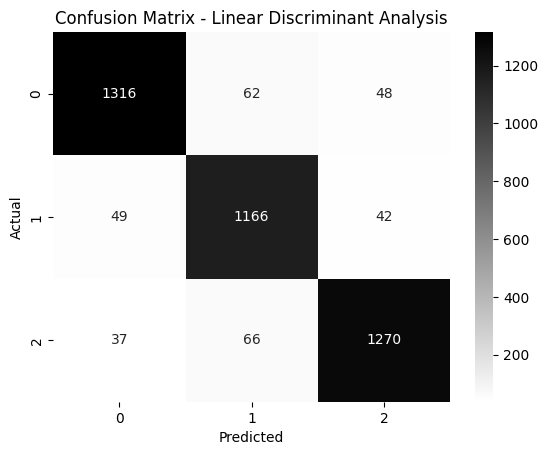

In [26]:
cm = confusion_matrix(y_test, y_pred5)
sns.heatmap(cm, annot=True, fmt='d', cmap='binary')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Linear Discriminant Analysis")
plt.show()

In [27]:
results['Method'].append('Linear Discriminant Analysis')
results['Accuracy'].append(accuracy)
results['Report'].append(classification_report(y_test, y_pred5))

## Linear SVM: One-vs-Rest

In [28]:
# OneVsRestClassifier with LinearSVC
svm_cv = OneVsRestClassifier(
    LinearSVC(
        max_iter=1000,      # Maximum iterations
        random_state=42,    # For reproducibility
        dual=False          # Use the primal form of the problem (faster for n_features > n_samples)
    )
)

svm_cv.fit(X_train_scaled, y_train)  # Train the model
y_pred6 = svm_cv.predict(X_test_scaled)  # Predictions
accuracy = accuracy_score(y_test, y_pred6)  # Evaluation

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_report(y_test, y_pred6))

Accuracy: 0.9339
Classification Report:
               precision    recall  f1-score   support

           3       0.94      0.94      0.94      1426
           5       0.93      0.91      0.92      1257
           8       0.93      0.94      0.94      1373

    accuracy                           0.93      4056
   macro avg       0.93      0.93      0.93      4056
weighted avg       0.93      0.93      0.93      4056



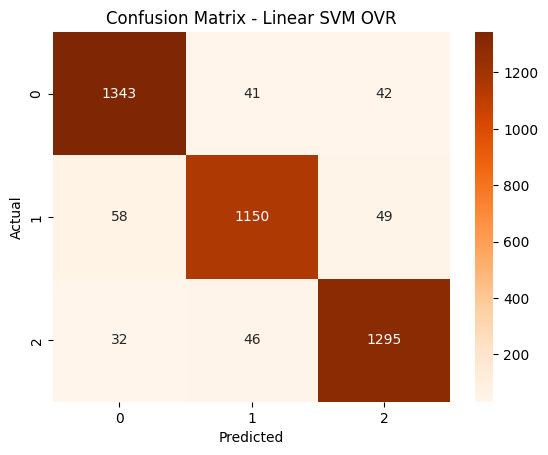

In [29]:
cm = confusion_matrix(y_test, y_pred6)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Linear SVM OVR")
plt.show()

These results are also very strong.  In general, I would claim that every method with the exception of Naive Bayes when assuming Gaussian Distribution are all strong methods and have their own pros and cons.

In [30]:
results['Method'].append('Linear SVM OVR')
results['Accuracy'].append(accuracy)
results['Report'].append(classification_report(y_test, y_pred6))

# Comparison Across Methods

Comparing the accuracy across methods.

In [31]:
df_accuracy = pd.DataFrame({'Method': results['Method'],
                          'Accuracy': results['Accuracy']
})

# df_accuracy = df_accuracy.sort_values(by='Accuracy', ascending = False)
df_accuracy

,Method,Accuracy
0,Logistic Regression OVR,0.937377
1,Multinomial Regression,0.938363
2,Naive Bayes (Gaussian),0.477811
3,Naive Bayes (Bernoulli),0.873274
4,Linear Discriminant Analysis,0.925049
5,Linear SVM OVR,0.933925


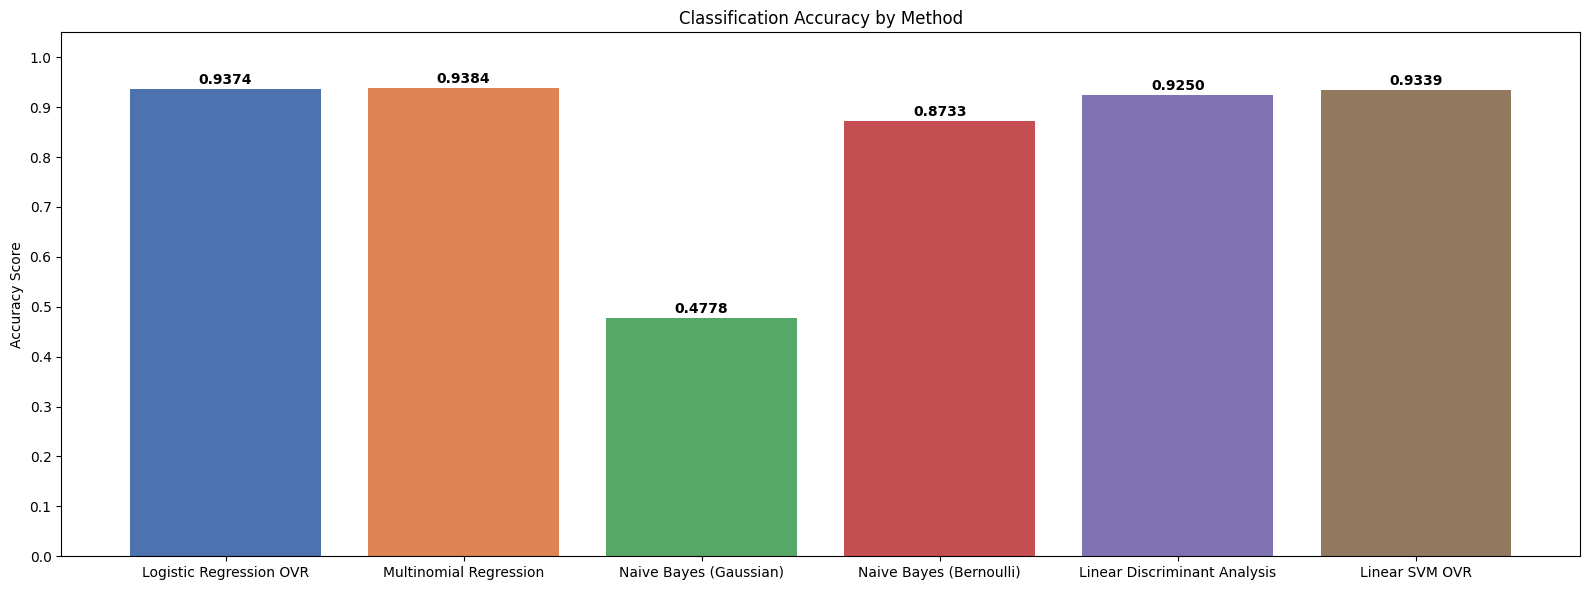

In [32]:
plt.figure(figsize=(16, 6))
colors = sns.color_palette("deep", len(results['Method']))
bars = plt.bar(df_accuracy['Method'], df_accuracy['Accuracy'], color=colors)

for bar, accuracy in zip(bars, df_accuracy['Accuracy']): # Add accuracy values on top of each bar
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.01,
        f'{accuracy:.4f}',
        ha='center',
        fontweight='bold'
    )

plt.yticks(np.arange(0, 1.1, 0.1)) # Add more y-axis ticks
plt.ylim(0, 1.05)
plt.ylabel('Accuracy Score')
plt.title('Classification Accuracy by Method')

plt.tight_layout() # Adjust layout

The confusion matrix's across all methods are given below to compare.

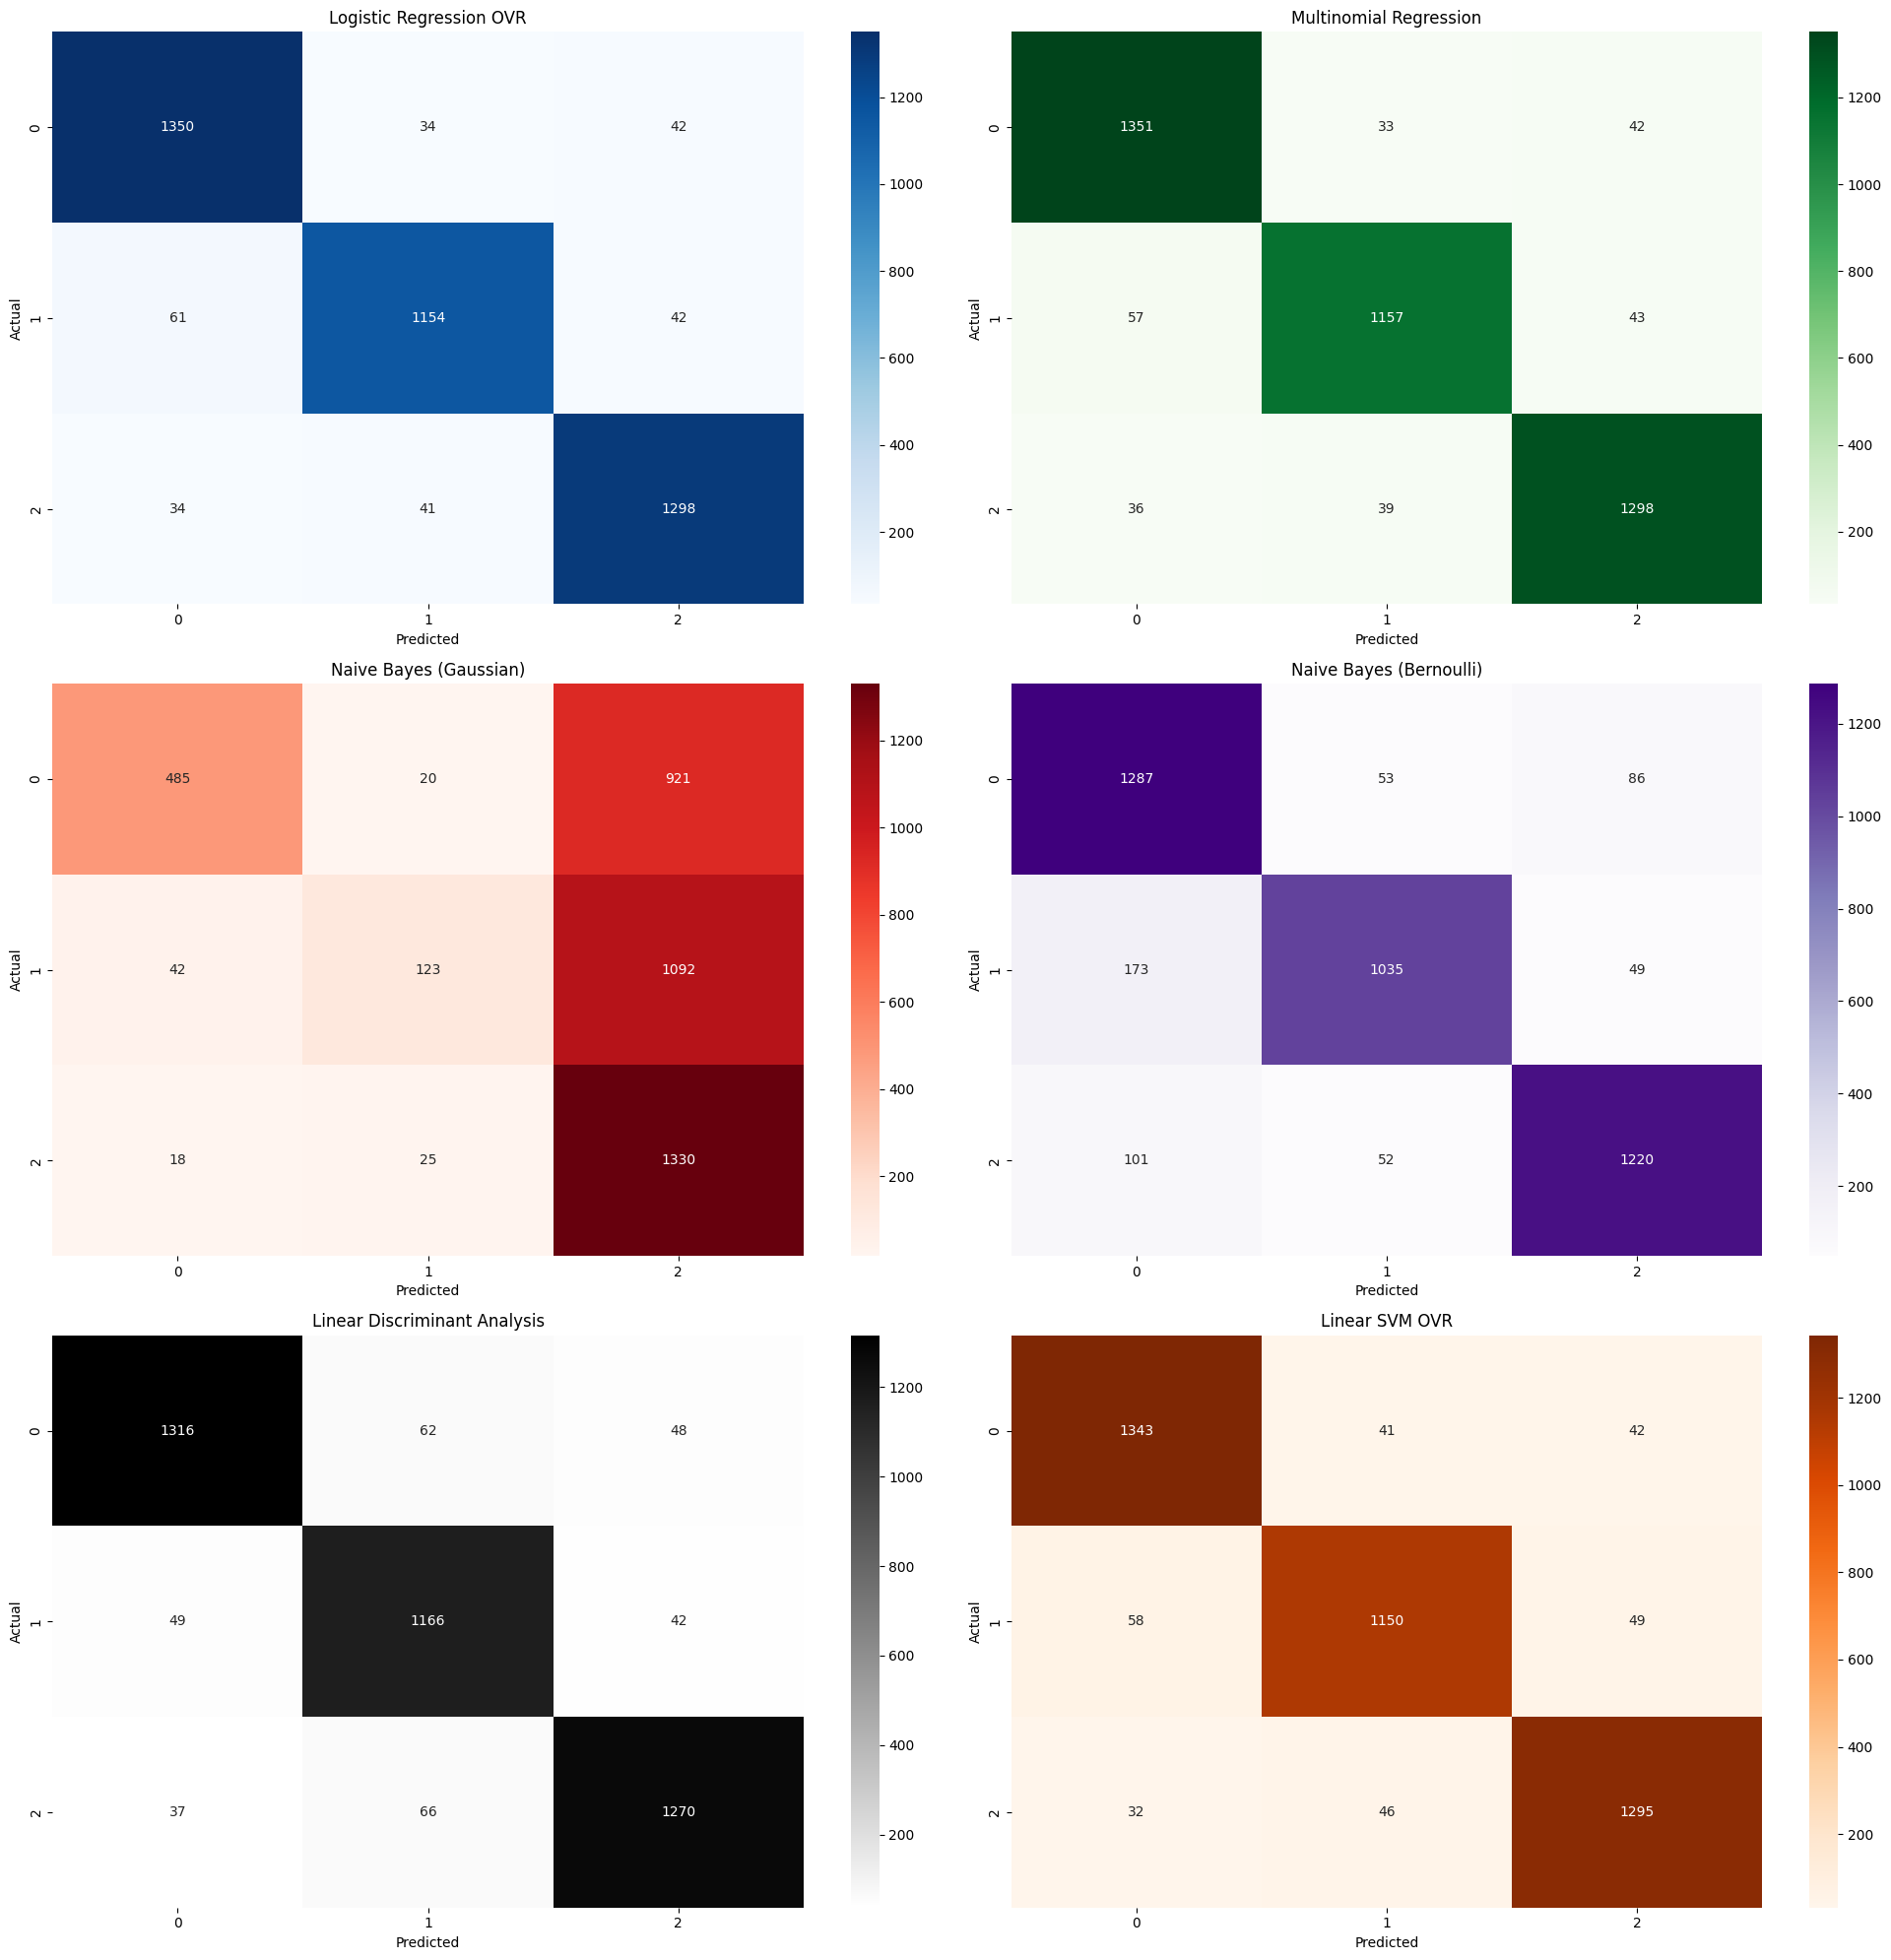

In [33]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20)) # Create a 3x2 grid of subplots
axes = axes.flatten() # Flatten the axes for easier iteration

colors = ['Blues', 'Greens', 'Reds', 'Purples', 'binary', 'Oranges']
y_preds = [y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6]
cms = [confusion_matrix(y_test, y_preds[i]) for i in range(len(y_preds))]
titles = results['Method']

for i, ax in enumerate(axes[:len(cms)]):
    sns.heatmap(cms[i], annot=True, fmt='d', cmap=colors[i], ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(titles[i])

plt.tight_layout() # Adjust layout so the subplots don't overlap
plt.show()


*End of Notebook.*